In [17]:
import numpy as np
import torch
from env import VanillaEnv
from policy import ActorNet
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from env import generate_expert_trajectory

In [18]:
def compare_imgs(a,b,c,title:str = ""):
   f, axarr = plt.subplots(1,3)
   axarr[0].imshow(np.flipud(a.squeeze()), cmap='gray', vmin=0., vmax=1.)
   axarr[1].imshow(np.flipud(b.squeeze()), cmap='gray', vmin=0., vmax=1.)
   axarr[2].imshow(np.flipud(c.squeeze()), cmap='gray', vmin=0., vmax=1.)
   if len(title) > 0: plt.title(title)
   plt.show()

In [19]:
model_name = './ckpts/Jun07_21-44-27_Manu-Desktop.pth'

# load the model
ckp = torch.load(model_name)
model = ActorNet()
model.load_state_dict(ckp['state_dict'])

<All keys matched successfully>

In [20]:
states_a1, actions_a1  = generate_expert_trajectory(VanillaEnv(configurations=[(26, 12)]))
states_a2, actions_a2  = generate_expert_trajectory(VanillaEnv(configurations=[(26, 28)]))

states_b1, actions_b1  = generate_expert_trajectory(VanillaEnv(configurations=[(34, 12)]))
states_b2, actions_b2  = generate_expert_trajectory(VanillaEnv(configurations=[(34, 28)]))
states_a1, states_a2, states_b1, states_b2 = torch.tensor(states_a1), torch.tensor(states_a2), torch.tensor(states_b1), torch.tensor(states_b2)

In [21]:
embeddings = []
labels = []
point_size = []

start_size = 30 

for i in range(states_a1.shape[0]):
    stacked = torch.stack((states_a1[i],states_a2[i],states_b1[i],states_b2[i]))
    embedding = model.forward(stacked, contrastive = True)

    embeddings.append(embedding[0])
    embeddings.append(embedding[1])
    embeddings.append(embedding[2])
    embeddings.append(embedding[3])

    pdist = nn.PairwiseDistance(p=2)
    a1_a2_dist = pdist(embedding[0], embedding[1]).item()
    a1_b1_dist = pdist(embedding[0], embedding[2]).item()
    if a1_a2_dist>a1_b1_dist: 
        print(f"distance to b1 smaller than to a2! Element {i}")
    labels += ['a1', 'a2', 'b1', 'b2']
    
    current_size = start_size + i*1.15
    point_size += [current_size, current_size, current_size, current_size] 

embeddings = torch.stack(embeddings).detach().numpy()
embeddings.shape

distance to b1 smaller than to a2! Element 8
distance to b1 smaller than to a2! Element 12
distance to b1 smaller than to a2! Element 28
distance to b1 smaller than to a2! Element 29
distance to b1 smaller than to a2! Element 32
distance to b1 smaller than to a2! Element 36
distance to b1 smaller than to a2! Element 41
distance to b1 smaller than to a2! Element 42
distance to b1 smaller than to a2! Element 43
distance to b1 smaller than to a2! Element 44
distance to b1 smaller than to a2! Element 45
distance to b1 smaller than to a2! Element 46
distance to b1 smaller than to a2! Element 47
distance to b1 smaller than to a2! Element 48
distance to b1 smaller than to a2! Element 49
distance to b1 smaller than to a2! Element 52
distance to b1 smaller than to a2! Element 53
distance to b1 smaller than to a2! Element 54
distance to b1 smaller than to a2! Element 55


(224, 64)

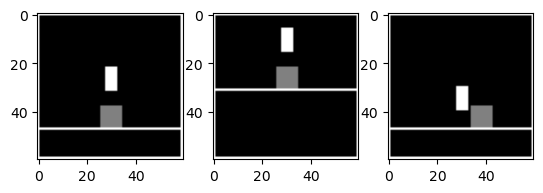

In [22]:
visualize_idx = 28

compare_imgs( states_a1[visualize_idx], states_a2[visualize_idx], states_b1[visualize_idx] )

In [23]:
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(embeddings)
tsne_result.shape

(224, 2)

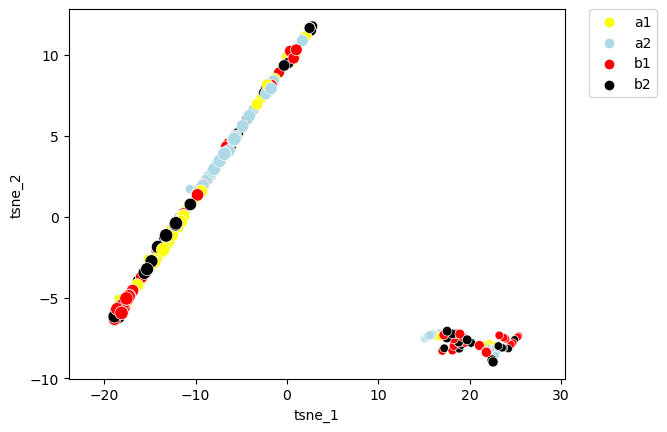

In [24]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': labels})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=point_size, palette=['yellow','lightblue','red','black'])
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
# ax.set_ylim(lim)
# ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)